#Protein Metrics

This notebook calculates various sequence- and structure-based quality scores for proteins, such as those produced by generative models. Many different kinds of metrics can be calculated. For all of the metrics, proteins with higher scores (closer to zero for negative numbers) are predicted to be more likely to fold and have function than proteins with lower scores.

**inputs**: Please provide protein sequences in fasta format, AlphaFold2-predicted structures, and/or reference protein sequences in fasta format as appropriate (see sections below).

**outputs**: A comma-separated values (csv) text file with the calculated metrics.


## Setup

In [ ]:
%%capture cap --no-stderr
#@title 1. Install dependencies and set up directories

# set up directories
!rm -r sample_data
!mkdir -p pdbs target_seqs reference_seqs

!mkdir -p /opt/bin 

#install esm
!pip -q install  git+https://github.com/facebookresearch/esm.git@e5e7b06b9a093706607c229ab1c5c9821806814d 

#install hmmer, mafft, emboss, biotite, and sequence-models
!apt-get -qq update > /dev/null
!apt-get -qq install  hmmer mafft emboss > /dev/null
!pip -q install  biotite pytest-datadir sequence-models > /dev/null

#install fasta3
!wget https://github.com/wrpearson/fasta36/releases/download/v36.3.8i_14-Nov-2020/fasta-36.3.8i-linux64.tar.gz > /dev/null
!tar xf fasta-36.3.8i-linux64.tar.gz > /dev/null
!mv fasta-36.3.8i/bin/* /opt/bin 
!rm -r fasta*

### FROM ESM-IF example notebook https://github.com/facebookresearch/esm/blob/e5e7b06b9a093706607c229ab1c5c9821806814d/examples/inverse_folding/notebook.ipynb
import torch
def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html > /dev/null
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html > /dev/null
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html > /dev/null
!pip install -q torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html > /dev/null
!pip install -q torch-geometric > /dev/null
!pip install -q pgen > /dev/null
### END OF CODE FROM ESM-IF


In [ ]:
#@title 2. Reset calculated metrics (creates a new datastructure to store results, clearing any existing results)

results = dict()
device = 'cuda:0'

from google.colab import files
import os
import re
import torch

#from sequence_models.utils import parse_fasta
from typing import List
from pgen.utils import parse_fasta
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from pathlib import Path
from glob import glob
from random import randrange
import esm
from biotite.structure.io import pdb
from biotite.structure import get_residue_count
from biotite.structure.residues import get_residues
from biotite.sequence import ProteinSequence
import tempfile
from Bio.Align import substitution_matrices
import subprocess
from dataclasses import dataclass

from sequence_models.pretrained import load_model_and_alphabet
from sequence_models.pdb_utils import parse_PDB, process_coords

def residues_in_pdb(pdb_path):
    with open(pdb_path) as f:
        pdb_file = pdb.PDBFile.read(pdb_path)
        atoms  = pdb_file.get_structure()
    return get_residue_count(atoms)

gap_open=10
gap_extend=2

def add_metric(metrics_dict, protein_name, metric_name, value):
  if protein_name not in metrics_dict:
    metrics_dict[protein_name] = dict()
  metrics_dict[protein_name][metric_name] = value

def get_pdb_sequence(pdb_path):
    with open(pdb_path) as f:
        pdb_file = pdb.PDBFile.read(pdb_path)
        atoms  = pdb_file.get_structure()
        residues = get_residues(atoms)[1]
    return ''.join([ProteinSequence.convert_letter_3to1(r) for r in residues])

with open("/tmp/PFASUM15.mat", "w") as f:
  f.write("""    A   R   N   D   C   Q   E   G   H   I   L   K   M   F   P   S   T   W   Y   V   B   Z   J   X   *
A   3  -1  -1  -1   0  -1   0   1  -1   0   0  -1  -1  -2   0   1   0  -2  -2   1  -7  -6  -6 -26  -6
R  -1   6   1   0  -3   2   1  -1   0  -4  -3   4  -2  -4   0   0   1  -3  -3  -3  -5  -4 -10 -26  -6
N  -1   1   6   3  -3   2   1   1   3  -5  -4   1  -1  -4   0   2   0  -5  -2  -4  -4  -4 -10 -26  -6
D  -1   0   3   8  -3   1   3   0   1  -5  -5   1  -5  -5   0   1   0  -5  -4  -4  -3  -3 -11 -27  -6
C   0  -3  -3  -3  16  -2  -1   0  -1   0   0  -4   2   1  -2   0   0   0  -2   1  -9  -7  -6 -26  -6
Q  -1   2   2   1  -2   5   3   0   1  -4  -4   2  -2  -3  -1   1   1  -1  -3  -3  -5  -5 -10 -26  -6
E   0   1   1   3  -1   3   6   0   1  -5  -4   3  -3  -6   0   0   0  -3  -3  -4  -4  -5 -10 -26  -6
G   1  -1   1   0   0   0   0   9   0  -4  -4   0  -2  -3   0   1  -1  -2  -4  -3  -5  -6 -10 -27  -6
H  -1   0   3   1  -1   1   1   0  10  -4  -3   1  -2  -1  -1   0   0   0   2  -2  -4  -5  -9 -26  -6
I   0  -4  -5  -5   0  -4  -5  -4  -4   5   4  -4   3   3  -4  -3  -1  -1   0   5 -11 -10  -3 -26  -6
L   0  -3  -4  -5   0  -4  -4  -4  -3   4   5  -4   2   3  -3  -3  -2   1   1   3 -10 -10  -5 -27  -6
K  -1   4   1   1  -4   2   3   0   1  -4  -4   5  -2  -4   0   1   0  -4  -2  -4  -5  -3 -10 -26  -6
M  -1  -2  -1  -5   2  -2  -3  -2  -2   3   2  -2   8   2  -2  -2   0   2   1   2  -9  -9  -4 -26  -6
F  -2  -4  -4  -5   1  -3  -6  -3  -1   3   3  -4   2   8  -3  -4  -2   5   5   1 -11 -11  -3 -26  -6
P   0   0   0   0  -2  -1   0   0  -1  -4  -3   0  -2  -3  12   0   0  -3  -2  -3  -6  -6 -10 -27  -6
S   1   0   2   1   0   1   0   1   0  -3  -3   1  -2  -4   0   4   2  -3  -2  -2  -5  -5  -9 -26  -6
T   0   1   0   0   0   1   0  -1   0  -1  -2   0   0  -2   0   2   3  -3  -1   0  -6  -6  -7 -26  -6
W  -2  -3  -5  -5   0  -1  -3  -2   0  -1   1  -4   2   5  -3  -3  -3  20   6  -2 -11  -8  -6 -27  -6
Y  -2  -3  -2  -4  -2  -3  -3  -4   2   0   1  -2   1   5  -2  -2  -1   6  10   0  -9  -9  -6 -26  -6
V   1  -3  -4  -4   1  -3  -4  -3  -2   5   3  -4   2   1  -3  -2   0  -2   0   5 -10 -10  -2 -26  -6
B  -7  -5  -4  -3  -9  -5  -4  -5  -4 -11 -10  -5  -9 -11  -6  -5  -6 -11  -9 -10  -5 -10 -17 -32  -6
Z  -6  -4  -4  -3  -7  -5  -5  -6  -5 -10 -10  -3  -9 -11  -6  -5  -6  -8  -9 -10 -10  -6 -16 -32  -6
J  -6 -10 -10 -11  -6 -10 -10 -10  -9  -3  -5 -10  -4  -3 -10  -9  -7  -6  -6  -2 -17 -16  -6 -33  -6
X -26 -26 -26 -27 -26 -26 -26 -27 -26 -26 -27 -26 -26 -26 -27 -26 -26 -27 -26 -26 -32 -32 -33 -40  -6
*  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6   1""")

with open("/tmp/BLOSUM62.mat", "w") as f:
  f.write("""   A  R  N  D  C  Q  E  G  H  I  L  K  M  F  P  S  T  W  Y  V  B  Z  X  *
A  4 -1 -2 -2  0 -1 -1  0 -2 -1 -1 -1 -1 -2 -1  1  0 -3 -2  0 -2 -1  0 -4 
R -1  5  0 -2 -3  1  0 -2  0 -3 -2  2 -1 -3 -2 -1 -1 -3 -2 -3 -1  0 -1 -4 
N -2  0  6  1 -3  0  0  0  1 -3 -3  0 -2 -3 -2  1  0 -4 -2 -3  3  0 -1 -4 
D -2 -2  1  6 -3  0  2 -1 -1 -3 -4 -1 -3 -3 -1  0 -1 -4 -3 -3  4  1 -1 -4 
C  0 -3 -3 -3  9 -3 -4 -3 -3 -1 -1 -3 -1 -2 -3 -1 -1 -2 -2 -1 -3 -3 -2 -4 
Q -1  1  0  0 -3  5  2 -2  0 -3 -2  1  0 -3 -1  0 -1 -2 -1 -2  0  3 -1 -4 
E -1  0  0  2 -4  2  5 -2  0 -3 -3  1 -2 -3 -1  0 -1 -3 -2 -2  1  4 -1 -4 
G  0 -2  0 -1 -3 -2 -2  6 -2 -4 -4 -2 -3 -3 -2  0 -2 -2 -3 -3 -1 -2 -1 -4 
H -2  0  1 -1 -3  0  0 -2  8 -3 -3 -1 -2 -1 -2 -1 -2 -2  2 -3  0  0 -1 -4 
I -1 -3 -3 -3 -1 -3 -3 -4 -3  4  2 -3  1  0 -3 -2 -1 -3 -1  3 -3 -3 -1 -4 
L -1 -2 -3 -4 -1 -2 -3 -4 -3  2  4 -2  2  0 -3 -2 -1 -2 -1  1 -4 -3 -1 -4 
K -1  2  0 -1 -3  1  1 -2 -1 -3 -2  5 -1 -3 -1  0 -1 -3 -2 -2  0  1 -1 -4 
M -1 -1 -2 -3 -1  0 -2 -3 -2  1  2 -1  5  0 -2 -1 -1 -1 -1  1 -3 -1 -1 -4 
F -2 -3 -3 -3 -2 -3 -3 -3 -1  0  0 -3  0  6 -4 -2 -2  1  3 -1 -3 -3 -1 -4 
P -1 -2 -2 -1 -3 -1 -1 -2 -2 -3 -3 -1 -2 -4  7 -1 -1 -4 -3 -2 -2 -1 -2 -4 
S  1 -1  1  0 -1  0  0  0 -1 -2 -2  0 -1 -2 -1  4  1 -3 -2 -2  0  0  0 -4 
T  0 -1  0 -1 -1 -1 -1 -2 -2 -1 -1 -1 -1 -2 -1  1  5 -2 -2  0 -1 -1  0 -4 
W -3 -3 -4 -4 -2 -2 -3 -2 -2 -3 -2 -3 -1  1 -4 -3 -2 11  2 -3 -4 -3 -2 -4 
Y -2 -2 -2 -3 -2 -1 -2 -3  2 -1 -1 -2 -1  3 -3 -2 -2  2  7 -1 -3 -2 -1 -4 
V  0 -3 -3 -3 -1 -2 -2 -3 -3  3  1 -2  1 -1 -2 -2  0 -3 -1  4 -3 -2 -1 -4 
B -2 -1  3  4 -3  0  1 -1  0 -3 -4  0 -3 -3 -2  0 -1 -4 -3 -3  4  1 -1 -4 
Z -1  0  0  1 -3  3  4 -2  0 -3 -3  1 -1 -3 -1  0 -1 -3 -2 -2  1  4 -1 -4 
X  0 -1 -1 -1 -2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -2  0  0 -2 -1 -1 -1 -1 -1 -4 
* -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4  1
""")

with open("/tmp/extract_mif.py", "w") as f:
  f.write("""import argparse

import torch.cuda
from tqdm import tqdm
import pandas as pd
import numpy as np

from sequence_models.utils import parse_fasta
from sequence_models.pretrained import load_model_and_alphabet
from sequence_models.pdb_utils import parse_PDB, process_coords


parser = argparse.ArgumentParser()
parser.add_argument('model')
parser.add_argument('tsv_fpath')
parser.add_argument('out_dir')
parser.add_argument('result')
parser.add_argument('--include', nargs='*', default=['mean'])
parser.add_argument('--device', default=None)
args = parser.parse_args()

# Check inputs
if args.model not in ['mif', 'mifst']:
    raise ValueError("Valid models ars 'mif' and 'mifst'.")
if args.result == 'logits':
    for inc in args.include:
        if inc not in ['per_tok', 'logp']:
            raise ValueError("logits can be included as 'per_tok' or as 'logp'.")
elif args.result == 'repr':
    for inc in args.include:
        if inc not in ['per_tok', 'mean']:
            raise ValueError("repr can be included as 'per_tok' or as 'mean'.")
else:
    raise ValueError("Valid results ars 'repr' and 'logits'.")

# load model
print('Loading model...')
model, collater = load_model_and_alphabet(args.model)
# detect device and move model to it
if args.device is None:
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
else:
    device = torch.device(args.device)
model = model.to(device)
# load data
print('Loading data...')
df = pd.read_table(args.tsv_fpath).reset_index()
if 'logp' in args.include:
    logps = np.empty(len(df))
with tqdm(total=len(df)) as pbar:
    for i, row in df.iterrows():
        seq = row['sequence']
        pdb = row['pdb']
        name = row['name']
        coords, wt, _ = parse_PDB(pdb)
        coords = {
            'N': coords[:, 0],
            'CA': coords[:, 1],
            'C': coords[:, 2]
        }
        dist, omega, theta, phi = process_coords(coords)
        batch = [[seq, torch.tensor(dist, dtype=torch.float),
                  torch.tensor(omega, dtype=torch.float),
                  torch.tensor(theta, dtype=torch.float), torch.tensor(phi, dtype=torch.float)]]
        src, nodes, edges, connections, edge_mask = collater(batch)
        src = src.to(device)
        nodes = nodes.to(device)
        edges = edges.to(device)
        connections = connections.to(device)
        edge_mask = edge_mask.to(device)
        rep = model(src, nodes, edges, connections, edge_mask, result=args.result)[0]
        if args.result == 'repr':
            if 'mean' in args.include:
                torch.save(rep.mean(dim=0).detach().cpu(),
                           args.out_dir + '_'.join([name, args.model, 'mean']) + '.pt')
            if 'per_tok' in args.include:
                torch.save(rep.detach().cpu(),
                           args.out_dir + '_'.join([name, args.model, 'per_tok']) + '.pt')
        else:
            if 'logp' in args.include:
                rep = rep.log_softmax(dim=-1)
                logps[i] = rep[torch.arange(len(src[0])), src].mean().detach().cpu().numpy()
            if 'per_tok' in args.include:
                torch.save(rep.detach().cpu(), args.out_dir + '_'.join([name, args.model, 'logits']) + '.pt')
        pbar.update(1)
    if 'logp' in args.include:
        df['logp'] = logps
        out_fpath = args.out_dir + args.model + '_logp.tsv'
        print('Writing results to ' + out_fpath)
        df = df.to_csv(out_fpath, index=False, sep="\t")
  """)

with open("/tmp/extract.py", "w") as f:
  f.write("""import argparse

import torch.cuda
from tqdm import tqdm
import numpy as np
import pandas as pd

from sequence_models.utils import parse_fasta
from sequence_models.pretrained import load_model_and_alphabet

parser = argparse.ArgumentParser()
parser.add_argument('model')
parser.add_argument('in_fpath')
parser.add_argument('out_dir')
parser.add_argument('--repr_layers', nargs='*', default=[-1])
parser.add_argument('--include', nargs='*', default=['mean'])
parser.add_argument('--device', default=None)
parser.add_argument('--batchsize', default=1, type=int)
args = parser.parse_args()

# load model
print('Loading model...')
model, collater = load_model_and_alphabet(args.model)
# detect device and move model to it
if args.device is None:
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
else:
    device = torch.device(args.device)
model = model.to(device)
# load data
print('Loading data...')
seqs, names = parse_fasta(args.in_fpath, return_names=True)
ells = [len(s) for s in seqs]
seqs = [[s] for s in seqs]
n_total = len(seqs)
repr_layers = []
for r in args.repr_layers:
    if r == 'logits':
        logits = True
    else:
        repr_layers.append(int(r))
if 'logp' in args.include:
    logps = np.empty(len(seqs))
with tqdm(total=n_total) as pbar:
    for i in range(0, n_total, args.batchsize):
        start = i
        end = start + args.batchsize
        bs = seqs[start:end]
        bn = names[start:end]
        bl = ells[start:end]
        # tokenize
        x = collater(bs)[0].to(device)
        # pass through the model
        results = model(x, repr_layers=repr_layers, logits=logits)
        if 'representations' in results:
            for layer, rep in results['representations'].items():
                for r, ell, name in zip(rep, bl, bn):
                    r = r[:ell]
                    if 'mean' in args.include:
                        torch.save(r.mean(dim=0).detach().cpu(),
                                   args.out_dir + '_'.join([name, args.model, str(layer), 'mean']) + '.pt')
                    if 'per_tok' in args.include:
                        torch.save(r.detach().cpu(),
                                   args.out_dir + '_'.join([name, args.model, str(layer), 'per_tok']) + '.pt')
        if logits:
            rep = results['logits']
            for r, ell, name, src in zip(rep, bl, bn, x):
                if 'per_tok' in args.include:
                    r = r[:ell]
                    torch.save(r.detach().cpu(), args.out_dir + '_'.join([name, args.model, 'logits']) + '.pt')
                if 'logp' in args.include:
                    r = r.log_softmax(dim=-1)[:ell]
                    # print(src.shape, r.shape)
                    logps[i] = r[torch.arange(len(src)), src].mean().detach().cpu().numpy()
        pbar.update(len(bs))
    if 'logp' in args.include:
        df = pd.DataFrame()
        df['name'] = names
        df['sequence'] = [s[0] for s in seqs]
        df['logp'] = logps
        out_fpath = args.out_dir + args.model + '_logp.tsv'
        print('Writing results to ' + out_fpath)
        df = df.to_csv(out_fpath, index=False, sep="\t")
""")

### 3. Upload files

Different files are required depending on which kinds of metrics you want to calculate.

Please upload protein PDB files or protein fasta files to the appropriate directories in `/content`

- Structures as PDB files (used for structure metrics). 
   - In this notebook we assume every strucure has a single chain, chain A.
   - pLDDT score assumes that the scores are stored in the b-factor field of the PDB file, which is the case for PDB files generated by AlphaFold2.
- Target sequences (used for single-sequence and alignment-based metrics)
  - If the directory contains more than one fasta file, metrics will be calculated for all sequences from all files in the directory.
- Reference sequences (used for alignment-based metrics)
  - If the directory contains more than one fasta file, all of them will be used as reference sequences.

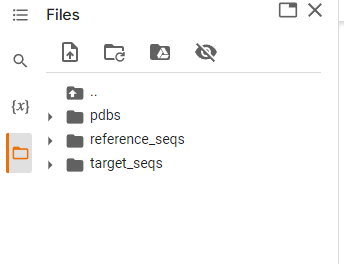




## Calculate Metrics

In [ ]:
#@title ## Structure Metrics

#@markdown Requires PDB uploaded files. All metrics will execute on all uploaded PDB files.

#@markdown __MIF-ST__


#@markdown __AlphaFold2 pLDDT__

#@markdown Average taken from the b-factors in AlphaFold2-produced pdb files.

#@markdown 

#@markdown ### __Metrics__
# CHECKBOXES

MIF_ST = True #@param {type:"boolean"}
AlphaFold2_pLDDT = True #@param {type:"boolean"}

 
 # MIF-ST

if MIF_ST: 
  with tempfile.TemporaryDirectory() as output_dir:
    spec_file_path = output_dir + "/spec_file.tsv"
    with open(spec_file_path, 'w') as f:
      f.write('name\tsequence\tpdb\n')
      for pdb_file in glob("/content/pdbs/*.pdb"):
        seq = get_pdb_sequence(pdb_file) 
        name = Path(pdb_file).stem
        f.write(name + '\t' + seq + '\t' + pdb_file + '\n')
    #print(spec_file_path)
    proc = subprocess.run(['python', "/tmp/extract_mif.py", "mifst", spec_file_path, output_dir + "/", "logits", "--include", "logp", "--device", device], stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
    # print(proc.stderr.decode("utf-8"))
    # print(proc.stdout.decode("utf-8"))
    df = pd.read_table(output_dir + '/mifst_logp.tsv')
    df = df.rename(columns={'name': 'id', 'logp': 'mifst_logp'}, )
    for _, row in df.iterrows():
      add_metric(results, row["id"], "MIF-ST", row["mifst_logp"])


  
# pLDDT
if AlphaFold2_pLDDT:
  for pdb_file in glob("/content/pdbs/*.pdb"):
    fstem = Path(pdb_file).stem
    name = fstem
    pdb_file = pdb.PDBFile.read(pdb_file)
    atoms = pdb_file.get_structure(extra_fields = ['b_factor'])
    prev_residue = -1
    plddt_sum = 0
    residue_count = 0
    for a in atoms[0]:
      if a.res_id != prev_residue:
        prev_residue = a.res_id
        residue_count += 1
        plddt_sum += a.b_factor
    add_metric(results, name, "AlphaFold2 pLDDT", plddt_sum/residue_count)


In [ ]:
#@title Single-sequence metrics

#@markdown __CARP-640m__


#@markdown ### __Metrics__
# CHECKBOXES
CARP_640m_logp = True #@param {type:"boolean"}


target_seqs_file = "/tmp/target_seqs.fasta"
with open(target_seqs_file,"w") as fh:
  for target_fasta in glob("/content/target_seqs/*"):
    for name, seq in zip(*parse_fasta(target_fasta, return_names=True, clean="unalign")):
      print(f">{name}\n{seq}", file=fh)

#CARP
if CARP_640m_logp: 
  with tempfile.TemporaryDirectory() as output_dir:
    proc = subprocess.run(['python', "/tmp/extract.py", "carp_640M", "/tmp/target_seqs.fasta", output_dir + "/", "--repr_layers", "logits", "--include", "logp", "--device", device], stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
    # print(proc.stderr)
    # print(proc.stdout)
    df = pd.read_table(output_dir + '/carp_640M_logp.tsv')
    df = df.rename(columns={'name': 'id', 'logp': 'carp640m_logp'},)
    for _, row in df.iterrows():
      add_metric(results, row["id"], "CARP-640m", row["carp640m_logp"])






In [ ]:
#@title Download results
# OPTION FOR 
df = pd.DataFrame.from_dict(results, orient="index")
df.to_csv(f"/tmp/calculated_metrics.csv")

files.download(f"/tmp/calculated_metrics.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Missing metrics
Phobius and Rosetta are discussed in the paper, but not available here because of licensing issues.